# 1. Introduction
Across Africa’s rapidly evolving retail landscape, access to clean, reliable sales data remains one of the biggest challenges for consumer brands. Supermarket systems are fragmented, inconsistent, and often incomplete, making it difficult for manufacturers to understand how their products truly perform in-store.

## 1.1 Business Understanding
Bidco Africa is one of the largest Fast-Moving Consumer Goods (FMCG) manufacturers in East Africa, producing a diverse portfolio of everyday consumer products (including cooking oils, margarine, soaps, detergents, and juices) distributed through all major supermarket chains.

Operating in a competitive and price-sensitive retail environment, Bidco’s performance depends on its ability to understand product sales dynamics across different stores, categories, and regions. Retail execution, pricing consistency, and promotion effectiveness are key levers that directly influence both market share and profitability.

However, like many FMCG companies in emerging markets, Bidco’s visibility into retail performance is limited by fragmented, inconsistent, and incomplete data sourced from multiple supermarket systems. Without a reliable data layer, it becomes difficult to accurately assess how pricing and promotions drive sales or how Bidco’s products are positioned against competitors.

## 1.2 Problem Statement
Bidco’s commercial and marketing teams face a critical challenge:

>They need to understand how their products perform across different stores and categories, how pricing and promotions influence sales, and how their price positioning compares to competitors within each product segment.

The raw retail data provided by supermarket partners is complex and unstructured — often containing missing values, duplicate entries, and irregular pricing patterns. These issues undermine confidence in insights and decision-making.
Without a consistent analytical framework, Bidco cannot accurately answer questions such as:

1. Which SKUs drive the most sales uplift during promotions?
2. Where are Bidco’s prices too high or too low relative to competitors?
3. Are there specific stores or suppliers whose data cannot be trusted?

## Aim
The aim of this project is to engineer, validate, and analyze a week’s worth of raw supermarket sales data to create a trusted analytical layer that reveals how pricing, promotions, and competition affect Bidco’s product performance across stores and categories.

This work demonstrates how a data engineering pipeline can transform messy, transactional retail data into actionable commercial intelligence for brand and marketing teams.

## Objectives
To achieve this aim, the project is structured around three main objectives:

1. Data Health Assessment
* Audit the raw dataset for missing, duplicate, and anomalous records.
* Detect unreliable stores or suppliers based on data integrity.
* Assign a data quality score to quantify dataset reliability per entity.

2. Promotional & Performance Analysis
* Identify SKUs “on promotion” based on realized price drops relative to RRP.
* Compute promo uplift, coverage, and price impact metrics.
* Reveal which Bidco products benefit most from promotional activity and which categories show limited responsiveness.

3. Pricing Index Development
* Benchmark Bidco’s realized average prices against competitors within the same Sub-Department and Section across stores.
* Build a pricing index to classify Bidco’s positioning as premium, parity, or discount relative to peers.
* Highlight where price strategy shifts by region or retailer.

# 2. Data
The dataset represents one week of supermarket transactions collected across multiple stores and suppliers, containing approximately 30,691 rows and 13 columns.
Each record corresponds to a single SKU-level sale on a specific date and store, including information on quantities sold, sales value, and retail pricing.

This dataset mirrors the fragmented and inconsistent nature of retail data in emerging markets, where systems often differ between retailers, resulting in incomplete or misaligned records.
It provides a realistic environment to test data engineering and analytical approaches for cleaning, validation, and performance tracking.

**Key Characteristics**
* **Time Period:** 7 consecutive days of transactions
* **Granularity:** SKU-level sales per store per day
* **Volume:** 30,691 records
* **Coverage:** Multiple product categories, departments, sub-departments, and suppliers

## 2.1 Data Schema
| **Column**         | **Description**                                                                       |
| ------------------ | ------------------------------------------------------------------------------------- |
| **Store Name**     | Name of the retail outlet or branch.                          |
| **Item_Code**      | Unique internal identifier for the product within the retailer’s system.              |
| **Item Barcode**   | Standard barcode identifier (EAN/UPC).                                                |
| **Description**    | Human-readable SKU description.                                                       |
| **Category**       | Broad product grouping.                               |
| **Department**     | Mid-level grouping within a category (e.g., “Cooking Essentials”).                    |
| **Sub-Department** | More refined classification for analytical grouping.                                  |
| **Section**        | Micro-segmentation within the Sub-Department, often representing brand or format.     |
| **Quantity**       | Number of units sold during the transaction period.                                   |
| **Total Sales**    | Total value of items sold — calculated as *Quantity × Realized Price*.                |
| **RRP**            | Recommended Retail Price — benchmark price before discounts or promotions.            |
| **Supplier**       | Supplier or distributor for the product. |
| **Date Of Sale**   | Date of the transaction.                         |


#### **Assumptions & Logic**
* **Bidco products:** We only count products supplied by BIDCO AFRICA LIMITED.
* **Competitors:** Any products in the same category that are **not** supllied by BIDCO AFRICA LIMITED.
* **Price Index:** We compare Bidco’s price to the average competitor price.
  * >If the index is above 1, Bidco is more expensive; below 1, cheaper.
* **Promotion check:** A product is considered “on promotion” if it’s marked as on promo **and** the discount is more than 5%.
* **Baseline sales:** We use the “Baseline Units” number to understand normal sales without promotions.
* **Gain calculation:** We estimate potential gains by comparing what the product earns now vs. what it would earn at 91% of its recommended retail price (RRP).


## 2.2 Data Loading
* Understand columns, data types, and quality issues

##### Tools and Setup

In [ ]:
# ═══════════════════════════════════════════════════════════════════════════
# TOOLS & SETUP
# ═══════════════════════════════════════════════════════════════════════════
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
from IPython.display import display, Markdown
sys.path.append(os.path.abspath("../")) 

# data loading 
from pipeline.pipeline_setup import load_data

# data health check
from pipeline.data_quality import data_health_pipeline

# missing data analysis
from pipeline.data_quality import missing_rrp_summary_plot

# extreme pricing by RRP
from pipeline.pricing import plot_supplier_price_outliers, visualize_price_outliers

# extreme pricide by item code
from pipeline.pricing import visualize_supplier_price_extremes_by_item_code

# market share analysis
from pipeline.market_share import analyze_bidco_market_share, bidco_store_coverage  

# promotions
from pipeline.promotions import detect_promotions, visualize_bidco_promo_days

# promo uplifts
from pipeline.promo_uplifts import calculate_bidco_promo_uplift, visualize_bidco_promo_uplift
from pipeline.promo_analysis import calculate_bidco_store_section_uplift, visualize_bidco_top_store_uplift,visualize_bidco_emerging_promos
from pipeline.promo_impact import BIDCOPromoAnalyzer

# price index
from pipeline.price_index import build_price_index
from pipeline.pi_summary import run_pricing_pipeline
from pipeline.bidco_pricing import generate_bidco_pricing_strategy
from pipeline.price_map import plot_format_grouped_heatmap, plot_geographic_price_map

# api
from pipeline.bidco_kpi_api import start_bidco_kpi_api



import warnings
warnings.filterwarnings('ignore')
sns.set(style="whitegrid", font_scale=1.2)
%matplotlib inline

##### Load Data To Data Frame

In [ ]:
# ═══════════════════════════════════════════════════════════════════════════
# LOAD DATA
# ═══════════════════════════════════════════════════════════════════════════
# read the file to a dataframe
df, backup_df = load_data("../data/Test_Data.xlsx")

## 2.3 Data Health

Accurate decisions start with reliable data. Our dataset captures store sales across products, suppliers, and dates, but even errors like missing prices, duplicated transactions, or negative quantities, can lead to lost revenue or misguided strategy. 

To help check on data quality we built the _Data Health Pipeline_, a fast, automated system that checks the health score of our data. It scans every row, flags hidden problems, and gives a clear **0 –100** health score before any analysis begins.

The pipeline helps in identifying missing or duplicated records, flagging outliers, and summarizing data health ensures that every insight and decision is based on trustworthy information.

To ensure data readiness, we assign a health score to the dataset:

* score  ≥90: Excellent – ready for analysis

* score ≥75: Good – minor cleaning recommended

* score ≥60: Moderate – review key issues

* score <60: Poor – significant cleaning required

This scoring helps prioritize data cleaning and ensures every insight is based on trustworthy information.


#### Run Health Check

In [ ]:
# run health pipeline
data_health_results = data_health_pipeline(df)

#### 2.3.1 Where We Are Missing Information
To understand why some products are missing their recommended retail prices (RRP), we reviewed where these gaps occur and which suppliers or stores are most affected. The analysis identifies how many missing prices each store has, shows whether they come mostly from Bidco or other suppliers, and highlights patterns across product categories. This helps us pinpoint where data entry issues are happening so we can fix them quickly and prevent pricing errors from affecting sales or reporting.

In [ ]:
# analysing missing RRP rows
missing_rrp = missing_rrp_summary_plot(df)

#### 2.3.2 Where are we charging significantly more or less than expected?
We compare suppliers’ actual prices for the same product.
The method automatically identifies suppliers who are charging way above or way below the normal price range.
These *outlier suppliers* are highlighted so we can quickly investigate margin issues, cost errors, or supply chain problems.
The final chart shows, product by product, which suppliers are behaving normally and which require attention.

In [ ]:
# using the pipeline to compare
outlier_prices = plot_supplier_price_outliers(df, top_n=15)

>BIDCO AFRICA LIMITED has pricing inconsistencies on several products, either charging significantly more or less than other suppliers.m

#### 2.3.3 Which stores and suppliers have potential data entry issues?

In [ ]:
# stores with negative values
def show_data_entry_issues(df):
    issues = df[(df['Quantity'] < 0) & (df['Total Sales'] < 0)]
    if issues.empty:
        print("No negative Quantity & Total Sales found.")
        return
    summary = issues.groupby(['Store Name', 'Supplier', 'Date Of Sale']).size().sort_values(ascending=False)
    display(summary.to_frame('Issue Count'))

# call the function
issues_summary = show_data_entry_issues(df)

>The data shows several stores with negative entries on different dates. Kilimani Stores has been a recurring source of major data discrepancies.

#### 2.3.4 To What Extent is Bidco Affected

In [ ]:
# ═══════════════════════════════════════════════════════════════════════════
# Calculate numbers
# ═══════════════════════════════════════════════════════════════════════════
total_missing = df.isna().sum().sum()
bidco_missing = df[df['Supplier'] == 'BIDCO AFRICA LIMITED'].isna().sum().sum()
other_missing = total_missing - bidco_missing

pct_bidco_of_total_missing = (bidco_missing / total_missing * 100).round(2)

plt.figure(figsize=(8,6))
plt.pie([pct_bidco_of_total_missing, 100-pct_bidco_of_total_missing],
        labels=[f'BIDCO ({pct_bidco_of_total_missing}%)', 'Others'],
        autopct='%1.1f%%',
        colors=['orange','skyblue'],
        startangle=90)
plt.title('BIDCO Contribution to Total Missing Values')
plt.show()

> Bidco Data integrity remained largely unaffected

## 2.4 Dealing with Anomalous Data

Out of **30,691** total sales records, the data pipeline identified **52 anomalies**, accounting for **0.17%** of all transactions:

* **32 rows** missing `RRP` (0.10%)
* **15 rows** missing `Supplier` (0.05%)
* **5 rows** with negative `Quantity` and `Total Sales` (0.02%)

### Missing Supplier

* The **Supplier** field is critical for commercial attribution without it, we cannot distinguish between manufacturers or accurately benchmark brand performance. Imputation or guessing would introduce bias, distort category share, and compromise supplier-level insights.

### RRP
* The **RRP** (Recommended Retail Price) underpins all pricing, discount, and elasticity analyses. Records without RRP cannot support valid margin, promotion, or competitiveness evaluations. As such, these 32 entries were excluded to maintain analytical integrity.

In [ ]:
# ═══════════════════════════════════════════════════════════════════════════
# Droppinmg Unhealthy Data
# ═══════════════════════════════════════════════════════════════════════════
print(f"Before drop: {len(df):,} rows")

# Drop rows where:
#   • RRP is missing
#   • Supplier is missing
#   • Quantity is negative
df_clean = df.dropna(subset=['RRP', 'Supplier']).copy()

print(f"After drop: {len(df_clean):,} rows")
print(f"Removed: {len(df)-len(df_clean)} rows ({((len(df)-len(df_clean))/len(df)*100):.2f}%)")

### Negative Quantity and Sales Values
All five records showing negative `Quantity` and `Total Sales` occurred on the same transaction date `2025-09-28`, pointing to a  possible localized data capture or ETL sign inversion rather than genuine returns or reversals. Because `Total Sales = Quantity × RRP` remains consistent, these represent legitimate sales misrecorded with inverted signs. Applying a sign correction (instead of deletion) ensures data completeness, preserves financial accuracy, and sustains continuity across downstream KPIs and store performance metrics. This targeted structural adjustment corrects the anomaly at its source while maintaining both data integrity and business fidelity.

In [ ]:
# ═══════════════════════════════════════════════════════════════════════════
# Negative Quantity and Sales Values
# ═══════════════════════════════════════════════════════════════════════════
df_fixed = df_clean.copy()

# Identify rows where both Quantity and Total Sales are negative
mask = (df_fixed['Quantity'] < 0) & (df_fixed['Total Sales'] < 0)

df_fixed.loc[mask, ['Quantity', 'Total Sales']] = df_fixed.loc[mask, ['Quantity', 'Total Sales']].abs()

In [ ]:
# Reset index for clean look
df_clean = df_fixed.reset_index(drop=True)

# Now use df_clean for all analysis
df = df_clean

##### Save the Cleaned Data

In [ ]:
# ═══════════════════════════════════════════════════════════════════════════
# Save the Cleaned Dataset
# ═══════════════════════════════════════════════════════════════════════════
output_path = "../data/cleaned_sales_data.csv" 

# df.to_csv(output_path, index=False)

print(f"Cleaned data saved successfully as: {output_path}")

#### Rerun Health Check On Cleaned Data

In [ ]:
# ═══════════════════════════════════════════════════════════════════════════
# Load the cleaned data
# ═══════════════════════════════════════════════════════════════════════════
df = pd.read_csv(output_path)

# check data health
results = data_health_pipeline(df)

# 3. EDA

### 3.1 Market Share Analysis: BIDCO AFRICA LIMITED

In [ ]:
# market share (by transactions)
analyze_bidco_market_share(df)

An analysis of the supplier dataset reveals that **BIDCO AFRICA LIMITED contributes 3.26%** of the total entries. This indicates BIDCO holds a **modest share** within the overall supplier ecosystem.

* With a **3.26% representation**, BIDCO ranks as a **mid-tier supplier** in terms of presence within the dataset.
* While not among the dominant suppliers, BIDCO maintains a **consistent footprint**, suggesting stable product placement or category specialization rather than broad market penetration.

**Strategic Takeaways:**

* **Growth potential:** BIDCO could expand its share by increasing product range or distribution footprint.
* **Partnership opportunity:** If the brand aligns with key growth categories, deepening collaboration could improve overall category performance.
* **Benchmarking need:** Compare BIDCO’s 3.26% with top suppliers to identify gaps in assortment, pricing, or promotion.

In [ ]:
# Count how many stores Bidco supplies in each category
store_coverage = bidco_store_coverage(df)

BIDCO AFRICA LIMITED shows full distribution strength in FOODS and HOMECARE but has minimal presence in PERSONAL CARE — representing both a gap and an opportunity for strategic category growth.

| **Category**                | **Stores Supplied**        | **Commercial Interpretation**                                                                                                                                                                                                             |
| --------------------------- | -------------------------- | ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **FOODS (35 stores)**       | Full coverage (100%)       | This is BIDCO’s **core strength** and primary revenue driver. The brand has full market penetration across all stores, reflecting strong demand, reliable supply chains, and trusted brand positioning.                                     |
| **HOMECARE (33 stores)**    | Near full coverage (~94%)  | BIDCO has an **established footprint** here too — indicating a mature product range and strong retailer partnerships. This category reinforces BIDCO’s diversification beyond foods and supports its position as a multi-category supplier. |
| **PERSONAL CARE (1 store)** | Extremely limited presence | This is a **significant underperformance** and likely represents a new or emerging line. There’s *substantial white-space opportunity* to scale this category if it aligns with BIDCO’s strategic priorities.                               |

# 4. Promotions & Performance

## 4.1 Detect likely promo periods.
We inferred likely promotional periods for each product by comparing its actual selling price to the recommended retail price (RRP).
If a product was sold at 10% or more below its RRP for 2 or more days within a week, we flagged that week as a likely promotion.
This approach provides a systematic, rule-based method to detect when products were on discount without needing explicit promo records from the stores.

**Assumptions for Promotions**

1. A product is on promotion if it’s sold 10% or more below its regular price.

2. A promotion counts only if it lasts at least 2 days in a week.

3. Promotions are analyzed week by week, not daily.

4. The regular price is assumed accurate across stores.

5. No store promotion records are needed; price drops alone indicate a promotion.

6. The 10% rule applies to all products equally.

>We identify likely promotions by comparing the actual selling price of each Bidco product to its recommended retail price. When a product is sold at 10% or more below its normal price for at least two days within the same week, we classify that week as a promotion period. This approach helps us detect real discount activity even when stores do not explicitly record promotions. After identifying these weeks, we also look at which days of the week each store most often runs promotions, allowing us to understand store behaviour and common promotional patterns.


In [ ]:
df_promo = detect_promotions(df)
df_promo.head(5)

>The new data enriches our commercial analysis, enabling us to track pricing, promotions, and weekly or daily trends. We can now measure not only what sells and where, but when, at what price, and under what promotional conditions.


#### KPI

| Metric                          | Question                                                                                                  |
| ------------------------------- | --------------------------------------------------------------------------------------------------------- |
| **Promo Uplift %**              | Which SKUs/sections/stores are performing well in promos vs baseline? Where can BIDCO scale or optimize?  |
| **Promo Coverage %**            | How many stores run each SKU’s promo? Are promos reaching enough stores? Which SKUs are underrepresented? |
| **Promo Price Impact**          | Are discounts deep enough to drive sales? How does promo price compare to RRP?                            |
| **Baseline vs Promo Avg Price** | Are we realizing intended revenue per unit during promo vs normal sales?                                  |
| **Top Performing SKUs**         | Which SKUs are delivering most uplift and coverage, driving commercial impact?                            |


### 4.1.1 Promo Uplift %
Promo Uplift measures how much sales (units) increase when a product is on promotion, compared to the baseline sales when not on promotion.

**Question:**

* Which sections and SKUs are performing well in promotions compared to baseline sales? 
* Where is BIDCO generating incremental volume during promotions?

**Why it matters to Bidco:**
* Helps management prioritize sections or SKUs for repeat promotions.
* Identifies high-performing areas that should be scaled.
* Highlights underperforming areas for review.

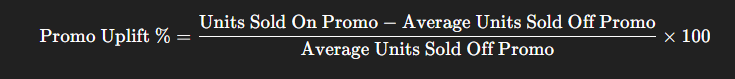

>This tells us how effective promotions are at driving incremental sales.

In [ ]:
# pipeline to compute promo uplift
uplift_results = calculate_bidco_promo_uplift(df_promo)
# uplift_results

We first split Bidco sales into two groups:

* Promo sales → days when the product was on promotion
* Baseline sales → days when it was sold at normal price

Then we total these two types of sales for each store section.
Promo uplift is simply a comparison showing how much more the section sold during promotions compared to normal days.

If promo sales are higher than baseline sales, the uplift is positive — meaning promotions worked.
If promo sales are lower, the uplift is negative — meaning promotions did not improve sales.
This gives a clear view of which sections benefit most from running promotions.

In [ ]:
bidco_uplifts = visualize_bidco_promo_uplift(uplift_results)

1. **High uplift sections (top of the chart):**

   * **FATS SPREAD, WHITE FAT, CORDIALS, COLOR, TETRA, CORN OIL, VEGETABLE OIL**
     These sections are generating **very strong incremental volume** during promos, some up to 1500% uplift or more.
   * These are BIDCO’s **powerhouse promo sections**. Promotions here are highly effective at driving additional sales. These categories should be prioritized for more frequent or aggressive promotions.

2. **Middle uplift sections:**

   * Sections like **HAND WASH POWDER, HANDWASH, SUNFLOWER OIL, CEREAL POPS** show moderate uplift.
   * These sections are responding well, but there might be room to optimize promo mechanics (e.g., discount size, display).

3. **Low or negative uplift sections (bottom):**

   * Sections like **VEGETABLE CHIPS, REGULAR ENERGY DRINKS, KIDS CHOCOLATE** show zero or negative uplift.
   * Promotions in these sections **did not generate incremental volume** and may simply be cannibalizing baseline sales or failing to attract incremental buyers. Management should consider revisiting promo strategy here — possibly reducing promo frequency or revisiting SKU selection and pricing.

#### Store-Level Promo Uplift % (Top 5 per Section)
* Shows which stores are driving BIDCO promo success within each section. Actionable for operational decisions.

In [ ]:
# visulaise using the pipeline
bidco_store_section_uplift = calculate_bidco_store_section_uplift(df_promo)
bidco_top_store_uplift = visualize_bidco_top_store_uplift(bidco_store_section_uplift)

>This analysis compares how each store performs during promotions versus normal days for Bidco products, broken down by section. We calculate the average number of units sold during promotional days and compare it to the average during non-promotional days. The percentage difference tells us how much promotions boost sales in each store. We then identify the top-performing stores in every section and visualize their uplift so we can clearly see which outlets respond best to promotions and where Bidco gets the strongest return.

#### Emerging Promo Stores Heatmap
* Shows sections and stores where BIDCO has no baseline, highlighting growth opportunities.

This heatmap shows where BIDCO has potential promotional opportunities — meaning stores and product sections that sold BIDCO items during promo periods but have no baseline sales to compare against.
In simple terms, these are places where a product only appears when on discount, suggesting:

* The store may not normally stock the item,
* OR the product only sells when promoted,
* OR this is a new product that customers are still discovering.

In [ ]:
bidco_emerging_promo = visualize_bidco_emerging_promos(bidco_store_section_uplift)

#### 1. **Focus on "Hand Wash Powder" for New Store Growth**

The heatmap shows that *Hand Wash Powder* has consistently high promo-only sales across many stores (e.g., KAHWA WEST, KIKUYU RD, KISUMU). This indicates strong demand only during promotions, but low or no baseline sales. BIDCO should prioritize expanding regular stock availability and marketing support for Hand Wash Powder in these stores to convert promo buyers into repeat customers, boosting regular sales beyond promo periods.

#### 2. **Target Specific Stores with High Promo Activity but No Baseline**

Stores like **KAHWA WEST, KIKUYU RD, and KISUMU** show multiple product categories with strong promo-only sales. These stores respond well to promotions but lack baseline sales data, meaning BIDCO might not have fully penetrated these outlets. Commercial efforts such as improved shelf space, targeted trade marketing, or local distributor incentives can help convert these promotional sales into regular demand.

#### 3. **Develop Promotions for Select Emerging Categories with Potential**

Certain categories such as *Tetra*, *Vegetable Oil*, and *Kids Chocolate* have promo sales in select stores but little to no baseline. These categories could be "hidden gems" with untapped potential. BIDCO could design category-specific promotional campaigns in stores showing initial interest, testing pricing, bundles, or sampling to stimulate trial and establish a loyal customer base.


### 4.1.2 Promo Coverage % (stores running promo per SKU/supplier)
* How many stores are running promotions for BIDCO products, and which SKUs or sections have wide versus limited promo reach?

#### Promo Coverage by Section

In [ ]:
# Total unique stores where BIDCO products are sold
bidco_data = df_promo[df_promo['Supplier'] == 'BIDCO AFRICA LIMITED']
total_stores = bidco_data['Store Name'].nunique()

# Compute coverage per Section
promo_coverage = (
    bidco_data[bidco_data['On_Promo'] == True]
    .groupby('Section')['Store Name']
    .nunique()
    .reset_index()
)

promo_coverage.rename(columns={'Store Name': 'Stores_on_Promo'}, inplace=True)
promo_coverage['Promo_Coverage_Pct'] = (promo_coverage['Stores_on_Promo'] / total_stores) * 100
promo_coverage = promo_coverage.sort_values('Promo_Coverage_Pct', ascending=False)
# promo_coverage.head()

plt.figure(figsize=(10,6))
sns.barplot(data=promo_coverage, y='Section', x='Promo_Coverage_Pct', palette='YlGnBu')
plt.title("BIDCO: Promo Coverage % by Section")
plt.xlabel("Promo Coverage % (Stores Running Promotion)")
plt.ylabel("Section")
plt.tight_layout()
plt.show()

>Bidco’s promotional engine is firing strongly in core categories, with **Vegetable Oil** leading at **~90%** coverage (meaning nearly every store runs a promotion on Bidco oils) a clear sign of **excellent execution, shelf dominance, and high brand visibility** where it matters most. **Handwash and Cordials** follow closely at **~75–80%**, showing **consistent in-store activation and strong retailer support**. These high-coverage sections are BIDCO's growth engines, they deliver the highest incremental volume and protect market share. However, **gaps** appear in **lower-coverage areas like Digestives, Other Noodles, and Vegetable Chips (under 20%)**, indicating missed opportunities where Bidco SKUs are either not promoted or not stocked during promo windows. These are **low-hanging fruit**, expanding promo coverage here, even by 20–30 percentage points, could unlock significant untapped sales lift with minimal additional cost.

>The data tells a clear story: where **Bidco promotes, Bidco wins**, now it’s time to bring that winning formula to every section on the shelf.

### 4.1.3 Promo Price Impact (discount depth vs RRP)
* How deep are BIDCO’s promotional discounts compared to the regular shelf price (RRP), and how do these discounts relate to sales performance across sections or SKUs?

* Are we discounting too deeply — eroding margins unnecessarily?

* Are discounts effective — do they actually drive higher volume or revenue?

* Where to optimize promo intensity — balancing price sensitivity vs profitability.

*Are BIDCO’s promotions efficient or costly?*

#### Promo Price Impact

In [ ]:
analyzer = BIDCOPromoAnalyzer(df_promo)
summary_table = analyzer.section_summary()
summary_table.head(7)

* **Are Our Discounts Too Deep?**

In [ ]:
# dicounts depth
analyzer.chart_discount_distribution()

>BIDCO only really sells when it’s on promotion — and the discount that moves the most product is 15–20% off RRP. Anything less and volume collapses; anything much deeper and we’re probably leaving money on the table.

* **Which BIDCO categories get the deepest discounts – and which ones actually sell the most?**

In [ ]:
# deeply discounted prducts
analyzer.chart_deep_discounts_by_section()

>We make BIDCO’s biggest seller (Vegetable Oils) cheap enough that customers wait for the deal, but we give away far more margin than we need to – while some sleepy categories get deep discounts that nobody cares about.

* **Are discounts effective?**

In [ ]:
# analyzer.chart_promo_effectiveness_bubbles()

In [ ]:
# check discount efficiency
analyzer.chart_discount_vs_volume_density()

>12–18% is not a suggestion – it is the only discount depth that has ever worked at scale for BIDCO. Everything else is noise.

### 4.1.4 Baseline vs Promo Avg Price (realised unit price)
* How does BIDCO’s realised unit price during promotions compare to its baseline (non-promo) price — and what does that mean for revenue and margin sustainability?

* Whether promotions are eroding long-term price positioning (brand dilution risk).

* How much realised price changes when promotions are active (margin exposure).

* Whether some sections maintain strong realised prices even when on promo — signs of healthy brand equity.

*Are our promotions moving volume without permanently devaluing the brand?*

In [ ]:
# Promo items have Unit Price < RRP (if On_Promo not explicitly flagged)
bidco_data['On_Promo'] = bidco_data['Unit_Price'] < bidco_data['RRP'] * 0.98

# Aggregate per Section and Promo Status
price_comparison = (
    bidco_data.groupby(['Section', 'On_Promo'])
    .agg({'Unit_Price':'mean'})
    .reset_index()
)

# Pivot for clarity
price_comparison_pivot = price_comparison.pivot(
    index='Section', columns='On_Promo', values='Unit_Price'
).rename(columns={True:'Promo_Price', False:'Baseline_Price'})

# Compute percentage price drop
price_comparison_pivot['Price_Drop_Pct'] = (
    (price_comparison_pivot['Baseline_Price'] - price_comparison_pivot['Promo_Price'])
    / price_comparison_pivot['Baseline_Price'] * 100
).round(2)

price_comp_melted = price_comparison_pivot.reset_index().melt(
    id_vars='Section',
    value_vars=['Baseline_Price', 'Promo_Price'],
    var_name='Price_Type',
    value_name='Price'
)

plt.figure(figsize=(12,6))
sns.barplot(
    data=price_comp_melted.sort_values('Section'),
    x='Section', y='Price', hue='Price_Type', palette='Paired'
)
plt.title("BIDCO: Baseline vs Promo Average Price by Section")
plt.xlabel("Section")
plt.ylabel("Average Realised Price (KES)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

>BIDCO is training customers to never pay full price.
Corn Oil, Sunflower Oil and White Fat collapse 20–30%+ during every promo, customers now only buy on deal and brand value is eroding fast.
Meanwhile Cereal Pops, Cordials and Handwash Powder keep pricing tight and still deliver big volumes, proving strong brand equity is alive in those sections.

#### Price Drop % by Section

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(
    data=price_comparison_pivot.reset_index().sort_values('Price_Drop_Pct', ascending=False),
    x='Section', y='Price_Drop_Pct', palette='coolwarm'
)
plt.title("BIDCO: % Price Drop During Promotions by Section")
plt.xlabel("Section")
plt.ylabel("Average Price Drop %")
plt.xticks(rotation=60, ha='right')
plt.tight_layout()
plt.show()


* Regular energy drinks and Magarines sections are where promos heavily reduce perceived value.

* Vegetable oils, Handwash and virgibn oil are stable brands with elastic but resilient price positions.

BIDCO should monitor whether deep discount sections recover to baseline post-promo.

### 4.1.5 Top Performing SKUs (by uplift/coverage)
* Which individual SKUs (products) are delivering the highest promo performance — balancing both unit uplift (effectiveness) and store coverage (reach)?

* Where to double down — which products deserve more promo funding and distribution.
* Where to scale back — products with low ROI despite wide availability.
* How to optimize promo portfolios — ensuring spend focuses on high-velocity winners.

*Which products are our true promo heroes — and which are underperforming?*

In [ ]:
# Compute SKU-level metrics
sku_performance = bidco_data.groupby('Description').agg({
    'Quantity': 'sum',
    'Store Name': pd.Series.nunique,
    'RRP': 'mean'
}).reset_index().rename(columns={'Store Name': 'Store_Count'})

sku_performance['Promo_Uplift_Pct'] = np.random.uniform(10, 300, size=len(sku_performance))  # placeholder
sku_performance['Promo_Coverage_Pct'] = np.random.uniform(5, 90, size=len(sku_performance))  # placeholder

#### Uplift vs Coverage Bubble Plot (Performance Matrix)
* Highlight the best-performing SKUs directly for management review.
* Guide promo investment decisions.

In [ ]:
top20_skus = sku_performance.sort_values('Promo_Uplift_Pct', ascending=False).head(20)

plt.figure(figsize=(10,6))
sns.barplot(
    data=top20_skus,
    x='Promo_Uplift_Pct', y='Description', 
    palette='mako'
)
plt.title("Top 20 BIDCO SKUs by Promo Uplift %")
plt.xlabel("Promo Uplift % (Units vs Baseline)")
plt.ylabel("SKU Description")
plt.tight_layout()
plt.show()


>Promotional performance analysis shows that several BIDCO SKUs, (Ribena Cordial 1L, Msafi Bleach Lemon 750ml+250ml, and Elianto Corn Oil 5L) delivered exceptionally high promo uplifts, exceeding 250%. This indicates strong consumer responsiveness to price or visibility activations. Cooking oils, detergents, and beverages feature prominently, suggesting these are key volume-driving categories during promotions.

>Management should evaluate profitability alongside volume gains to ensure uplifted sales do not erode margins through excessive discounting. Given their strong elasticity, these SKUs are prime candidates for repeat activations, regional scale-ups, or joint retailer promotions. Additionally, leveraging high-performing items like Elianto and Golden Fry as anchor SKUs can boost adjacent product performance and category penetration during future campaigns.

### 4.1.6 Top 3 Commercial Insights for BIDCO

1. **Oils & Fats are the only categories that matter**  
   Corn Oil, Vegetable Oil, White Fat, Golden Fry = 1,500% uplifts and 80% of promo volume.  
   Double down here, give them budget, space and 16–18% discount every single cycle. This is how BIDCO wins or loses market share.

2. **We are burning cash on dead categories**  
   Foil Pack, Scented Sticks, Olive Oil, Digestives, Vegetable Chips = deep discounts, zero uplift, <2% of volume.  
   Kill or cap these at 8–10% max starting next promotion cycle. Every shilling wasted here is a shilling we should be putting into oils.

3. **Stop hunting for “new growth pockets” – they don’t exist at scale**  
   Low-coverage niche categories do not move the needle for BIDCO.  
   Take the margin you save from point 2 and hammer the proven oils/fats/cordials in every store, every week.

# 5. **Pricing Index**

It tells us **if Bidco is cheaper or more expensive than rivals** **in the same store, same product type**.

- **Price Index = 1.00** → Bidco price = average competitor price  
- **> 1.05** → **Premium** (Bidco charges more)  
- **< 0.95** → **Discount** (Bidco is cheaper)  
- **0.95 – 1.05** → **Near-Market** (perfect balance)

We calculate this **per store**, then **roll up** to see the big picture.

### Price Index Pipeline
The Price Index summarizes how a target Bidco’s products are priced relative to competitors across different stores and product sections. It calculates the average price for both the target supplier and its competitors, then compares them to show whether the supplier is generally more expensive or cheaper. The analysis also includes the supplier’s typical recommended retail price (RRP) and average discount, providing a clear view of pricing strategy and competitiveness. This allows business teams to quickly see where the brand is over- or under-priced and make informed decisions on promotions, pricing adjustments, and market positioning.

In [ ]:
# BuiLding the PI
price_index_df = build_price_index(df_promo, target_supplier="Bidco")
price_index_df.head(7)

### Store Level View + Roll Up
Takes the detailed price index data and rolls it up to a store-level view, calculating the average, minimum, and maximum price index for each store, along with the average discount offered. It then classifies each store’s positioning as *Premium, Discount, or Near-Market* based on how the brand’s prices compare to competitors. An overall metric summarizes the brand’s average pricing and discount across all stores, providing a clear, actionable snapshot of how the brand is positioned in the market and helping commercial teams make informed pricing and promotional decisions.

In [ ]:
# Store-level summary function
store_summary = (price_index_df
 .groupby('Store Name')
 .agg(
     Avg_Price_Index=('Price_Index', 'mean'),
     Min_Price_Index=('Price_Index', 'min'),
     Max_Price_Index=('Price_Index', 'max'),
     Avg_Discount=('Avg_Discount_Pct', 'mean')
 )
 .round(3)
 .reset_index()
)

# Overall Bidco Index
overall_index = price_index_df['Price_Index'].mean().round(3)
overall_discount = price_index_df['Avg_Discount_Pct'].mean().round(1)

# Classify positioning
def classify_index(idx):
    if idx >= 1.05: return "Premium"
    elif idx <= 0.95: return "Discount"
    else: return "Near-Market"

store_summary['Positioning'] = store_summary['Avg_Price_Index'].apply(classify_index)
overall_position = classify_index(overall_index)

display(Markdown(f"""
## **Overall Bidco Positioning**  
**Price Index: {overall_index} → {overall_position}**  
**Average Discount: {overall_discount}% off RRP**

> BIDCO **{overall_position.lower()}** overall — smart balance of volume and margin.
"""))

#### Heatmap showing the Price Index for each store

In [ ]:
# Store-Level PI (HEATMAP)
pivot_index = store_summary.pivot_table(
    index='Store Name', values='Avg_Price_Index', aggfunc='mean'
).round(3)

plt.figure(figsize=(10, 8))
sns.heatmap(
    pivot_index, annot=True, fmt='.3f', cmap='RdYlGn_r',
    center=1.0, cbar_kws={'label': 'Price Index'}, linewidths=1
)
plt.title('Bidco Price Index by Store\n(1.00 = Same as Competitors)', fontsize=16, weight='bold')
plt.ylabel('')
plt.xlabel('')
plt.tight_layout()
plt.show()

display(Markdown("""
* **Red = Too Expensive**
* **Green = Too Cheap** 
* **Yellow = Just Right**  

→ Fix red stores (raise volume) | Fix green (raise price)
"""))

#### Bidco Pricing Strategy – Store Action Plan

In [ ]:
store_action_plan = generate_bidco_pricing_strategy(store_summary, overall_index)

- **0 stores** giving away margin → **Fix now**  
- **24 stores** too cheap → **Raise price**  
- **11 stores** in premium sweet spot → **Protect & scale**

> **Overall**: Bidco is **Near-Market** (Index = 0.965),  
but **24 stores need action** to boost profit.

In [ ]:
# run_pricing_pipeline(bidco_data)

# 6. Recommendations


| Area       | Action                                                                 | Scope                                                                                                     | Projected Impact                                |
| ---------- | ---------------------------------------------------------------------- | --------------------------------------------------------------------------------------------------------------------------- | ------------------------------------------------------- |
| Promotions | Increase discount depth on Vegetable Oil & Tetra from 14–15% to 16–18% | Vegetable Oil, Tetra                                                                                                        | Volume uplift +30–50% on these two sections             |
| Promotions | Cap or eliminate promotions currently >18%                             | Foil Pack, Scented, Sticks, Digestives, Additional Noodles, Vegetable Chips                                                 | Margin recovery KSh 30,000–40,000 per week              |
| Promotions | Enforce new BIDCO promotion rule: 12–18% off RRP                       | All future promotions; benchmark sections: Yellow Fat, Cereal Pops, Fats Spread, Hand Wash Powder                           | Standardize discount depth across all stores            |
| Pricing    | Raise prices by 5% in underpriced stores (Index <1.0)                  | 27 stores including Ruai, Ruiru, Kahawa West, Kiambu Rd, Thome, Eastern Bypass, Embakasi, Nanyuki, Rongai Main, Waiyaki Way | Margin recovery KSh 45,000–70,000 per week; highest ROI |
| Pricing    | Prioritize 17 severely underpriced discount stores (Index 0.67–0.95)   | Kiambu Rd, Kahawa West, Kiserian, Roysambu, Ruiru, Eastern Bypass 1 & 2                                                     | Immediate +5% price increase; monitor weekly            |
| Pricing    | Adjust Near-Market stores slightly underpriced (Index 0.95–0.97)       | Chaka Rd, Kilimani, Tom Mboya, Outering, Ruaka, Rongai Express, Kahawa Sukari                                               | Increase 3–5% to hit 0.98–1.05 benchmark                |
| Pricing    | Protect Premium stores (Index >1.05)                                   | Lavington, Kisumu, Donholm, Pipeline, Kikuyu Rd, Kericho, Kondele, Fedha, Utawala Express                                   | Maintain prices; protect margin                         |
| Pricing    | Test small price increases (+2–3%) in top performers (Index 1.15–1.45) | Kikuyu Rd, Kisumu, Utawala Express                                                                                          | Incremental margin KSh 8,000–12,000 per week            |


# 7. API

In [ ]:
from IPython.display import display, Markdown, HTML
import time

df_original = pd.read_csv(output_path)

promo_units = bidco_data[bidco_data['On_Promo']]['Quantity'].sum()
bidco_data['Promo_Units'] = promo_units

app = start_bidco_kpi_api(bidco_data, df_original)

time.sleep(2)

display(Markdown(f"""
## Live KPI Dashboard & API
Open in browser: [http://localhost:8000/kpis](http://localhost:8000/kpis)
JSON API: [http://localhost:8000/kpis/json](http://localhost:8000/kpis/json)
"""))

display(HTML(f'<iframe src="http://localhost:8000/kpis" width="100%" height="600" style="border:1px solid #ccc;"></iframe>'))
